References:   
https://www.kaggle.com/code/robikscube/sign-language-recognition-eda-twitch-stream  
（https://www.youtube.com/watch?v=DTQA8KIWWhY）  
https://www.kaggle.com/code/markwijkhuizen/aslfr-eda-preprocessing-dataset  

In [1]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
base_path='/kaggle/input/asl-fingerspelling/'

In [22]:
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re

sns.set_palette("colorblind")

In [3]:
# Install nb_black for autoformatting
!pip install nb_black --quiet
%load_ext lab_black

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [74 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib
      copying nb_black.py -> build/lib
      copying lab_black.py -> build/lib
      /opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running install
      running install_lib
      creating build/bdist.linux-x86_64
      creating build/bdist.linux-x86_64/wheel
      copying build/lib/lab_black.py -> build/bdist.linux-x86_64/wheel
      copying build/lib/nb_black.py -> build/bdist.linux-x86_64/wheel
      running install_egg_info
      running egg_info
      writing nb_black.egg-info/PKG-INFO
      writing dependency_links to nb_black.egg-info/dependency_links.txt
    

ModuleNotFoundError: No module named 'lab_black'

In [7]:
train = pd.read_csv(f'{base_path}/train.csv').head(1000)

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

train.info()
train.head()

N_SAMPLES: 1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            1000 non-null   object
 1   file_id         1000 non-null   int64 
 2   sequence_id     1000 non-null   int64 
 3   participant_id  1000 non-null   int64 
 4   phrase          1000 non-null   object
dtypes: int64(3), object(2)
memory usage: 39.2+ KB


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [5]:
with open(base_path+'character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
      
N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'CHAR2ORD: {CHAR2ORD}\nN_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

# Character to Ordinal Encoding Mapping   
pd.Series(CHAR2ORD).to_frame('Ordinal Encoding').head()

# # Way 2: convert dictionary to pandas dataframe
# CHAR2ORD_DF = pd.DataFrame(CHAR2ORD.values(),index=CHAR2ORD.keys(),columns=['Ordinal Encoding'])
# CHAR2ORD_DF.head()

CHAR2ORD: {' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}
N_UNIQUE_CHARACTERS: 59


,Ordinal Encoding
,0
!,1
#,2
$,3
%,4


In [21]:
# The way to look at kaggle kernel environment
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
os.environ['KAGGLE_KERNEL_RUN_TYPE'] 

'Interactive'

In [47]:
# Add complete file path to train
def get_file_path(path):
    return f'{base_path}{path}'

train['file_path'] = train['path'].apply(get_file_path)
train.head()

,path,file_id,sequence_id,participant_id,phrase,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...


In [23]:
"""
Attempt to retrieve phrase type
Could be used for pretraining or type specific inference
Phone Number/URL/Addres
"""
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)
train.head()


,path,file_id,sequence_id,participant_id,phrase,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,address


In [24]:
# Split Phrase To Char Tuple
train['phrase_char'] = train['phrase'].apply(tuple)
# Character Length of Phrase
train['phrase_char_len'] = train['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = train.set_index('sequence_id')

train.head()

MAX_PHRASE_LENGTH: 31


,path,file_id,sequence_id,participant_id,phrase,phrase_type,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,address,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,url,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,address,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,address,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,address,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


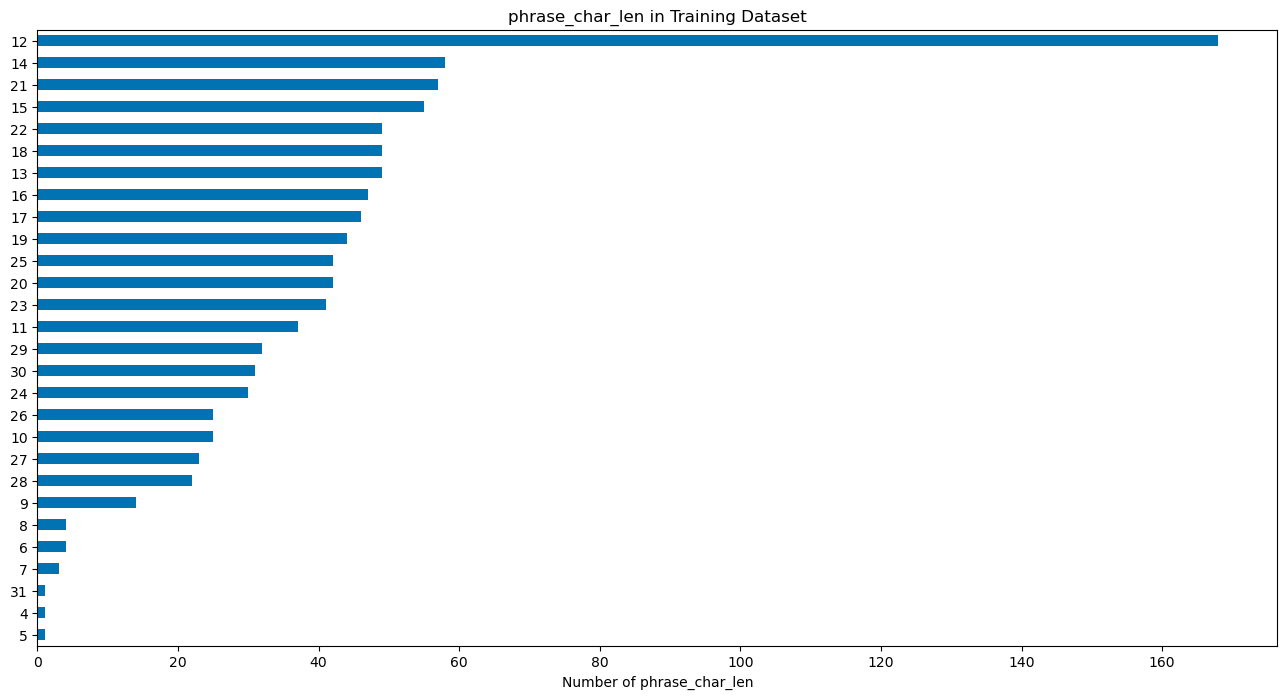

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
train["participant_id"].value_counts().head(50).sort_values(ascending=True).plot(
    kind="barh", ax=axes[0], title="Top 50 participant_ids in Training Dataset"
)
axes[0].set_xlabel("Number of Training Examples")
 
train["participant_id"].value_counts().tail(50).sort_values(ascending=True).plot(
    kind="barh", ax=axes[1], title="Bottom 50 participant_ids in Training Dataset"
)
axes[1].set_xlabel("Number of participant_id")

plt.tight_layout()
plt.show()


In [49]:
# supplemental_landmarks_path='/kaggle/input/asl-fingerspelling/supplemental_landmarks'
# test_path='/kaggle/input/asl-fingerspelling/supplemental_landmarks/1032110484.parquet'
# data = pd.read_parquet(test_path)
# data.head()

example_parquet_df=pd.read_parquet(train['file_path'][0])
# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')

example_parquet_df.head()

# Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
